In [1]:
import alkanes
from alkanes import *

import nglview as nv
from rdkit import Chem, DataStructs, RDConfig, rdBase
from rdkit import rdBase
from rdkit.Chem import AllChem, TorsionFingerprints
from rdkit.Chem import Draw,PyMol,rdFMCS
from rdkit.Chem.Draw import IPythonConsole

/home/tgog/.conda/envs/my-rdkit-env/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


importing alkanes
1
3
5
7
2
4
6
8
9
11
13
15
17
glug glug


In [2]:
def load_from_sdf(sdf_file):
    """
    """
    suppl = Chem.SDMolSupplier(sdf_file, removeHs=False) #, strictParsing=False
    sdf_mols = [mol for mol in suppl]
    return sdf_mols

In [3]:
mols = load_from_sdf('./alkanes/alkanes.sdf') 

x = [
    [-60.00000000000001, 180.0, -59.99999999999999, -59.99999999999993, -59.99999999999993, -60.0000000000001, 59.999999999999986],
    [-60.00000000000002, 180.0, 180.0, 179.99999999999997, 179.99999999999997, 180.0, -59.99999999999996],
    [59.99999999999999, 180.0, 180.0, 180.0, 180.0, 180.0, 179.99999999999997],
    [-180.0, 180.0, 180.0, -180.0, 59.99999999999999, 180.0, 180.0],
    [180.0, 180.0, -180.0, 180.0, 60.00000000000001, -59.999999999999986, -180.0],
    [180.0, 180.0, 60.00000000000001, 180.0, 180.0, 59.99999999999999, 179.99999999999997],
    [-59.99999999999999, 180.0, -180.0, 180.0, 59.99999999999996, -180.0, -180.0],
    [-60.00000000000002, 180.0, 180.0, 179.99999999999997, -180.0, 59.999999999999986, -180.0],
    [-180.0, 180.0, -180.0, 180.0, 180.0, -180.0, 180.0],
]

m = mols[-1]

m = Chem.rdmolops.AddHs(m)
AllChem.EmbedMultipleConfs(m, numConfs=10)
Chem.AllChem.MMFFOptimizeMoleculeConfs(m)
nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)

for i, torsions in enumerate(x):
    conf = m.GetConformer(id=i)

    for idx, tors in enumerate(nonring):
        atoms, ang = tors
        tup = atoms[0]
        deg = Chem.rdMolTransforms.GetDihedralDeg(conf, *tup)
        Chem.rdMolTransforms.SetDihedralDeg(conf, *tup, x[i][idx])


rmslist = []
AllChem.AlignMolConformers(m, RMSlist=rmslist)

In [4]:
nv.show_rdkit(m)

NGLWidget()

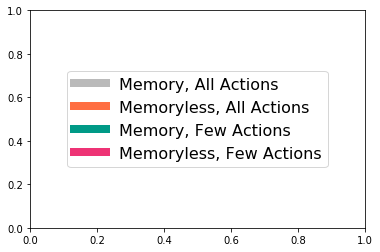

In [5]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color='#bababa', lw=8, label='Memory, All Actions'),
                   Line2D([0], [0], color='#ff6e42', lw=8, label='Memoryless, All Actions'),
                   Line2D([0], [0], color='#009a87', lw=8, label='Memory, Few Actions'),
                   Line2D([0], [0], color='#ee3375', lw=8, label='Memoryless, Few Actions'),
]

# Create the figure
fig, ax = plt.subplots()
ax.legend(handles=legend_elements, loc='center', prop={'size': 16})

plt.show()

In [6]:
mols = load_from_sdf('./alkanes/alkanes.sdf') 
mols += load_from_sdf('./alkanes/pentane.sdf')
mols += load_from_sdf('./alkanes/heptane.sdf') 
mols += load_from_sdf('./alkanes/nonane.sdf') 
mols += load_from_sdf('./alkanes/11_alkane.sdf') 
mols += load_from_sdf('./alkanes/12_alkane.sdf') 
mols += load_from_sdf('./alkanes/14_alkane.sdf') 
mols += load_from_sdf('./alkanes/16_alkane.sdf') 
mols += load_from_sdf('./alkanes/18_alkane.sdf') 
mols += load_from_sdf('./alkanes/20_alkane.sdf') 

mols_by_rbn = {}

for mol in mols:
    m = Chem.rdmolops.AddHs(mol)
    AllChem.EmbedMolecule(m)
    nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
    conf = m.GetConformer(id=0)
    for tors in nonring:
        atoms, ang = tors
        tup = atoms[0]
        deg = Chem.rdMolTransforms.GetDihedralDeg(conf, *tup)
        Chem.rdMolTransforms.SetDihedralDeg(conf, *tup, 180.0)

    Chem.AllChem.MMFFOptimizeMolecule(m)

    atoms = m.GetNumAtoms()
    rbn = Chem.rdMolDescriptors.CalcNumRotatableBonds(m) - 2 
    print(rbn)
    mols_by_rbn[rbn] = m
  

1
3
5
7
2
4
6
8
9
11
13
15
17


In [7]:
confgen = ConformerGeneratorCustom(max_conformers=1, 
                 rmsd_threshold=None, 
                 force_field='mmff',
                 pool_multiplier=1)  

energy_max = {}
for num, mol in sorted(mols_by_rbn.items()):
    energy = np.exp(-1.0 * confgen.get_conformer_energies(mol)[0])
    print(num, energy)
    energy_max[num] = energy

1 160.12797518189774
2 194.756965160818
3 238.51611372293712
4 292.85919841313324
5 359.91076491826277
6 442.49139781194947
7 544.1167226100808
8 669.1430293768832
9 822.9365241808027
11 1244.7759568933693
13 1882.9274480778226
15 2848.2820127879236
17 4308.58861588194


In [8]:
def get_n(rbn):
    if rbn <= 3:
        n = 25
    elif rbn == 4 or rbn == 5:
        n = 50
    elif rbn == 6 or rbn == 7:
        n = 100
    else:
        n = 200
        
    return n

In [9]:
from itertools import product
from sortedcontainers import SortedList
import time
import numpy as np

n_s = []
z_max_s = []
for num, m in sorted(mols_by_rbn.items()):

#     m = mols_by_rbn[3]
    nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
    conf = m.GetConformer(id=0)


    summ = 0
    combs = 0
    
    n = get_n(num)
    sl = SortedList()
    
    times = []
    for comb in product(*[[-1,0,1]] * num):
        ff = Chem.rdForceFieldHelpers.MMFFGetMoleculeForceField(m, Chem.rdForceFieldHelpers.MMFFGetMoleculeProperties(m))
        desired_torsions = []
        for idx, tors in enumerate(nonring):

            atoms, ang = tors
            tup = atoms[0]
            deg = Chem.rdMolTransforms.GetDihedralDeg(conf, *tup)
            Chem.rdMolTransforms.SetDihedralDeg(conf, *tup, 180.0 + 120 * comb[idx])
            tors = 180.0 + 120 * comb[idx]
            desired_torsions.append(tors)
            ff.MMFFAddTorsionConstraint(*tup, False, tors, tors,  10000.0)

        ff.Initialize()
        start = time.process_time()
        ff.Minimize()
        times.append(time.process_time() - start)

        nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
        conf = m.GetConformer(id=0)
        tups = [atoms[0] for atoms, ang in nonring]
        degs = [Chem.rdMolTransforms.GetDihedralDeg(conf, *tup) for tup in tups]

        dist = np.linalg.norm(np.sin(np.array(degs) * np.pi / 180.) - np.sin(np.array(desired_torsions) * np.pi / 180.))
        dist += np.linalg.norm(np.cos(np.array(degs)* np.pi / 180.) - np.cos(np.array(desired_torsions) * np.pi / 180.))

        if dist > 0.1:
            print('desired torsions', desired_torsions)
            print('actual torsions', degs)
            print(dist)
            energy = np.exp(-1.0 * confgen.get_conformer_energies(m)[0])
            print(energy)
        
            raise Exception
        
        energy = np.exp(-1.0 * confgen.get_conformer_energies(m)[0])
        sl.add(energy)
        if len(sl) > n:
            sl.pop(0)
        summ += energy
        combs += 1
        
    print(num, 'total is', summ)
    print('number of conformations is', combs)
    print('max is', energy_max[num])
    print('Z/max ratio is', summ / energy_max[num])
    print('top n conformers is', sum(sl))
    print('mean time', np.array(times).mean())

    
    n_s.append(num)
    z_max_s.append(summ / energy_max[num])

1 total is 298.29769537885295
number of conformations is 3
max is 160.12797518189774
Z/max ratio is 1.8628705886026535
top n conformers is 298.29769537885295
mean time 0.001434847666666646
2 total is 586.8618883267173
number of conformations is 9
max is 194.756965160818
Z/max ratio is 3.0133037236543703
top n conformers is 586.8618883267173
mean time 0.0022017510000002082
3 total is 1165.9633949377717
number of conformations is 27
max is 238.51611372293712
Z/max ratio is 4.88840513430538
top n conformers is 1165.963387826585
mean time 0.0034014954444443963
4 total is 2335.3407089356747
number of conformations is 81
max is 292.85919841313324
Z/max ratio is 7.974278156840528
top n conformers is 2333.1421805363616
mean time 0.004937891543209905
5 total is 4616.326479223461
number of conformations is 243
max is 359.91076491826277
Z/max ratio is 12.826308433069093
top n conformers is 3560.2608521845386
mean time 0.006832604065843579
6 total is 9457.892931618184
number of conformations is 72

KeyboardInterrupt: 

In [10]:
AllChem.MMFFOptimizeMoleculeConfs(m)
energy = np.exp(-1.0 * confgen.get_conformer_energies(m)[0])
print(energy)
nv.show_rdkit(m)


38.329151945663604


NGLWidget()

In [11]:
nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
conf = m.GetConformer(id=0)
ang = Chem.rdMolTransforms.GetDihedralDeg(conf, 3, 2, 1, 0)
print(tups, degs)
print(ang)
nv.show_rdkit(m)

[(0, 1, 2, 3), (1, 2, 3, 4), (2, 3, 4, 5), (3, 4, 5, 6), (4, 5, 6, 7), (5, 6, 7, 8), (6, 7, 8, 9)] [60.008577462338565, 179.99070460319786, -179.99911166619032, 179.98869562542555, 60.01061246004672, 179.98875884292838, -179.99955841618615]
65.62743633003419


NGLWidget()

In [60]:
from rdkit.Geometry.rdGeometry import Point3D
def PointRotate3D(p1, p2, p0, theta):
    from numpy import cos, sin, sqrt

    # Translate so axis is at origin    
    p = p0 - p1
    # Initialize point q
    q = Point3D(0.0,0.0,0.0)
    N = (p2-p1)
    Nm = sqrt(N.x**2 + N.y**2 + N.z**2)
    
    # Rotation axis unit vector
    n = Point3D(N.x/Nm, N.y/Nm, N.z/Nm)

    # Matrix common factors     
    c = cos(theta)
    t = (1 - cos(theta))
    s = sin(theta)
    X = n.x
    Y = n.y
    Z = n.z

    # Matrix 'M'
    d11 = t*X**2 + c
    d12 = t*X*Y - s*Z
    d13 = t*X*Z + s*Y
    d21 = t*X*Y + s*Z
    d22 = t*Y**2 + c
    d23 = t*Y*Z - s*X
    d31 = t*X*Z - s*Y
    d32 = t*Y*Z + s*X
    d33 = t*Z**2 + c

    #            |p.x|
    # Matrix 'M'*|p.y|
    #            |p.z|
    q.x = d11*p.x + d12*p.y + d13*p.z
    q.y = d21*p.x + d22*p.y + d23*p.z
    q.z = d31*p.x + d32*p.y + d33*p.z

    # Translate axis and rotated point back to original location    
    return q + p1

In [13]:
def setRingDihedralDeg(conf, iAtomId, jAtomId, kAtomId, lAtomId, value):
    rIJ = conf.GetAtomPosition(jAtomId) - conf.GetAtomPosition(iAtomId);
    rIJSqLength = rIJ.LengthSq();
    if (rIJSqLength <= 1.e-16):
        raise Exception("atoms i and j have identical 3D coordinates");

    rJK = conf.GetAtomPosition(kAtomId) - conf.GetAtomPosition(jAtomId);
    rJKSqLength = rJK.LengthSq();

    if (rJKSqLength <= 1.e-16):
        raise ValueErrorException("atoms j and k have identical 3D coordinates");

    rKL = conf.GetAtomPosition(lAtomId) - conf.GetAtomPosition(kAtomId);
    rKLSqLength = rKL.LengthSq()
    if (rKLSqLength <= 1.e-16):
        raise ValueErrorException("atoms k and l have identical 3D coordinates");

    nIJK = rIJ.CrossProduct(rJK);
    nIJKSqLength = nIJK.LengthSq();
    nJKL = rJK.CrossProduct(rKL);
    nJKLSqLength = nJKL.LengthSq();
    m1 = nIJK.CrossProduct(rJK);
    # we only need to rotate by delta with respect to the current dihedral value
    value *= (np.pi / 180)
    value -= -np.arctan2(m1.DotProduct(nJKL) / np.sqrt(nJKLSqLength * m1.LengthSq()),
                  nIJK.DotProduct(nJKL) / np.sqrt(nIJKSqLength * nJKLSqLength));
    # our rotation axis is the (j,k) bond
    rotAxisBegin = conf.GetAtomPosition(jAtomId);
    rotAxisEnd = conf.GetAtomPosition(kAtomId);
    rotAxis = rotAxisEnd - rotAxisBegin
    rotAxis.Normalize()
    # get all atoms bonded to k and loop through them
    # std::list<unsigned int> alist;
    # _toBeMovedIdxList(mol, jAtomId, kAtomId, alist);
    # for (unsigned int &it : alist) {
    # translate atom so that it coincides with the origin of rotation
    pos = conf.GetAtomPosition(lAtomId)

    # rotate around our rotation axis
    p = PointRotate3D(rotAxisBegin, rotAxisEnd, pos, value)
    conf.SetAtomPosition(lAtomId, p)

In [14]:
def print_dihedrals(conf):
    m = conf.GetOwningMol()
    nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
    print('nonring')
    for idx, tors in enumerate(nonring):
        atoms, ang = tors
        tup = atoms[0]
        deg = Chem.rdMolTransforms.GetDihedralDeg(conf, *tup)
        print(tup, deg)

#     print('ring')        
#     for tors in ring:
#         deg = Chem.rdMolTransforms.GetDihedralDeg(conf, *tors)
#         print(tors, deg)
#     print('\n\n\n')

In [15]:
def add_torsion_constraints(ff, tors_list, rotate=0, minimize=False):
    tors_list = tors_list[rotate:] + tors_list[:rotate]
    
    tors = tors_list[0]
    ff.MMFFAddTorsionConstraint(0, 5, 4, 3, False, tors - 0.1, tors + 0.1, 10000.0)
    tors = tors_list[1]
    ff.MMFFAddTorsionConstraint(5, 4, 3, 2, False, tors - 0.1, tors + 0.1, 10000.0)
    tors = tors_list[2]
    ff.MMFFAddTorsionConstraint(4, 3, 2, 1, False, tors - 0.1, tors + 0.1,  10000.0)
    tors = tors_list[3]
    ff.MMFFAddTorsionConstraint(3, 2, 1, 0, False, tors - 0.1, tors + 0.1,  10000.0)
    tors = tors_list[4]
    ff.MMFFAddTorsionConstraint(2, 1, 0, 5, False, tors - 0.1, tors + 0.1,  10000.0)
    tors = tors_list[5]
    ff.MMFFAddTorsionConstraint(1, 0, 5, 4, False, tors - 0.1, tors + 0.1,  10000.0)


In [16]:
def get_radial_hist(series, N, title='decane φ histogram'):
    bottom = 2

    # create theta for 24 hours
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

    # make the histogram that bined on 24 hour
    radii, tick = np.histogram(torsions, bins = N)

    # width of each bin on the plot
    width = (2*np.pi) / N

    # make a polar plot
    plt.figure(figsize = (12, 8))
    ax = plt.subplot(111, polar=True)
    bars = ax.bar(theta, radii, width=width, bottom=bottom)

    # set the lable go clockwise and start from the top
    ax.set_theta_zero_location("N")
    # clockwise
    ax.set_theta_direction(-1)

    # set the label
    ticks = ['180/-180', '-135', '-90', '-45', '0', '45', '90', '135']
    ax.set_xticklabels(ticks)
    plt.title(title)
    plt.show()

In [17]:
m = Chem.MolFromSmiles('C1CCCCC1')
m = Chem.AddHs(m)
AllChem.EmbedMultipleConfs(m, numConfs=1)
res = AllChem.MMFFOptimizeMoleculeConfs(m)
nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
ring = ring[0][0]

print_dihedrals(conf)
    
w = nv.show_rdkit(m)
w.add_label(labelType="atomindex", color='blue')
w

nonring
(0, 1, 2, 3) 65.6274363300342
(1, 2, 3, 4) 175.65471864130112
(2, 3, 4, 5) 179.70337227319013
(3, 4, 5, 6) 175.0472502470207
(4, 5, 6, 7) 67.19928875300288
(5, 6, 7, 8) 179.63816051557347
(6, 7, 8, 9) -66.81014143020393


NGLWidget()

In [18]:
ff = rdkit.Chem.rdForceFieldHelpers.MMFFGetMoleculeForceField(m, rdkit.Chem.rdForceFieldHelpers.MMFFGetMoleculeProperties(m))

# ff.MMFFAddTorsionConstraint(0, 5, 4, 3, False, 180.0, 180.0, 10000.0)
# ff.MMFFAddTorsionConstraint(5, 4, 3, 2, False, 180.0, 180.0, 10000.0)
# ff.MMFFAddTorsionConstraint(4, 3, 2, 1, False, 180.0, 180.0,  10000.0)
# ff.MMFFAddTorsionConstraint(3, 2, 1, 0, False, 180.0, 180.0,  10000.0)
# ff.MMFFAddTorsionConstraint(2, 1, 0, 5, False, 180.0, 180.0,  10000.0)
# ff.MMFFAddTorsionConstraint(1, 0, 5, 4, False, 180.0, 180.0,  10000.0)

# ff.MMFFAddTorsionConstraint(0, 5, 4, 3, False, -29.2, -29.0, 10000.0)
# ff.MMFFAddTorsionConstraint(5, 4, 3, 2, False, 60.0, 60.2, 10000.0)
# ff.MMFFAddTorsionConstraint(4, 3, 2, 1, False, -29.2, -29.0, 10000.0)
# ff.MMFFAddTorsionConstraint(3, 2, 1, 0, False, -29.2, -29.0, 10000.0)
# ff.MMFFAddTorsionConstraint(2, 1, 0, 5, False, 60.0, 60.2, 10000.0)
# ff.MMFFAddTorsionConstraint(1, 0, 5, 4, False, -29.2, -29.0, 10000.0)

add_torsion_constraints(ff, [-29.1675, 60.106, -29.1675, -29.1675, 60.106, -29.1675], rotate=1)


# add_torsion_constraints(ff, [-54.2, 54.2, -54.2, 54.2, -54.2, 54.2])


# add_torsion_constraints(ff, [-46, -26,  -5,  25, -13, 65])

ff.Initialize()
ret = ff.Minimize(maxIts=500)
print(ret)

# AllChem.MMFFOptimizeMolecule(m)


NameError: name 'rdkit' is not defined

In [19]:
AllChem.MMFFOptimizeMoleculeConfs(m)
print_dihedrals(m.GetConformers()[0])
w = nv.show_rdkit(m)
w.add_label(labelType="atomindex", color='blue')
w

nonring


NGLWidget()

In [20]:
import numpy as np
k = np.random.randint(-80, 80, size=(1,5))
print(k)
print(0 - k.sum())
help(np.random.randint)

[[-11  22 -45 -38 -15]]
87
Help on built-in function randint:

randint(...) method of mtrand.RandomState instance
    randint(low, high=None, size=None, dtype='l')
    
    Return random integers from `low` (inclusive) to `high` (exclusive).
    
    Return random integers from the "discrete uniform" distribution of
    the specified dtype in the "half-open" interval [`low`, `high`). If
    `high` is None (the default), then results are from [0, `low`).
    
    Parameters
    ----------
    low : int
        Lowest (signed) integer to be drawn from the distribution (unless
        ``high=None``, in which case this parameter is one above the
        *highest* such integer).
    high : int, optional
        If provided, one above the largest (signed) integer to be drawn
        from the distribution (see above for behavior if ``high=None``).
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are

In [10]:
lignin = Chem.MolFromMolFile('lignin_guaiacyl.mol')
lignin = Chem.AddHs(lignin)
AllChem.EmbedMultipleConfs(lignin, numConfs=200, numThreads=0)


In [11]:
AllChem.MMFFOptimizeMoleculeConfs(lignin, numThreads=0)
confgen = ConformerGeneratorCustom(max_conformers=200, 
                 rmsd_threshold=1.0, 
                 force_field='mmff',
                 pool_multiplier=1)  
print(get_conformer_rmsd_fast(lignin))
lignin, mat = confgen.prune_conformers(lignin, get_conformer_rmsd_fast(lignin))
print(lignin)
print(mat)
energys = confgen.get_conformer_energies(lignin)
energys = energys - energys.min()

print(len(energys))
for idx, x in enumerate(np.argsort(np.exp(-1 * energys))):
    print(idx, x, energys[x])

sum([np.exp(-1.0 * energy) for energy in energys])

Calculating RMSDs of conformer 17:   8%|▊         | 17/200 [00:00<00:02, 88.17it/s]

[[0.         2.51341789 2.46682594 ... 2.82644099 2.95397018 2.21829281]
 [2.51341789 0.         3.33935114 ... 3.01942889 2.64580214 1.89592476]
 [2.46682594 3.33935114 0.         ... 2.99927744 2.89974243 3.05335522]
 ...
 [2.82644099 3.01942889 2.99927744 ... 0.         2.34724684 2.82106578]
 [2.95397018 2.64580214 2.89974243 ... 2.34724684 0.         2.54041655]
 [2.21829281 1.89592476 3.05335522 ... 2.82106578 2.54041655 0.        ]]


Calculating RMSDs of conformer 77: 100%|██████████| 78/78 [00:00<00:00, 363.02it/s]


[[0.         1.15061446 2.71309494 ... 1.87619354 2.82299799 3.1030537 ]
 [1.15061446 0.         2.65592399 ... 2.24558168 3.17203276 3.41591798]
 [2.71309494 2.65592399 0.         ... 2.51252132 2.56854242 2.57441059]
 ...
 [1.87619354 2.24558168 2.51252132 ... 0.         1.64897866 2.00377788]
 [2.82299799 3.17203276 2.56854242 ... 1.64897866 0.         1.00869217]
 [3.1030537  3.41591798 2.57441059 ... 2.00377788 1.00869217 0.        ]]
78
0 77 32.88997572861217
1 76 18.798913841058237
2 75 13.037495662265997
3 74 12.486534367001497
4 73 12.147989189375949
5 72 11.920836592678967
6 71 11.879190612253836
7 70 9.98186121002287
8 69 9.672004249844548
9 68 9.603411521086073
10 67 9.505375387942351
11 66 9.402550007233188
12 65 9.384811082205857
13 64 8.24481243839493
14 63 8.224809729416975
15 62 8.008929710023267
16 61 7.900660463691139
17 60 7.881931075842431
18 59 7.468627794606064
19 58 7.4239112176808675
20 57 7.103403872218493
21 56 7.098523563053135
22 55 6.9000839007702695
23 54

3.3177874324660084

In [100]:
from importlib import reload
reload(alkanes)


importing alkanes
1
3
5
7
2
4
6
8
9
11
13
15
17
glug glug


<module 'alkanes' from '/home/tgog/conformer-ml/alkanes.py'>

In [25]:
print_dihedrals(lignin.GetConformer(id=65))

nonring
(2, 1, 4, 5) 109.95452772236031
(4, 1, 2, 14) -70.47384547154269
(4, 1, 0, 3) 60.82350066591667
(6, 5, 4, 1) -130.48425939239382
(5, 6, 11, 12) -87.77955039456553
(15, 14, 2, 1) -62.30409743597846
(22, 20, 18, 19) 102.65082000412097
(23, 21, 19, 18) -168.70716035588583


In [26]:
out = np.array(AllChem.GetConformerRMSMatrix(lignin))
np.argmin(out)
out[2965]

3.2143269034144786

In [27]:
x = get_conformer_rmsd_fast(lignin)



Calculating RMSDs of conformer 199: 100%|██████████| 200/200 [00:01<00:00, 147.18it/s]


In [ ]:
np.sum(x>4.05)

In [ ]:
np.nonzero(x>4.05)


In [ ]:
#39,77 and 45,86 are very similar

print_dihedrals(lignin.GetConformer(33))
print_dihedrals(lignin.GetConformer(82))

In [19]:
import py3Dmol
def drawit(m, p, confId=-1):
    mb = Chem.MolToMolBlock(m, confId=confId)
    p.removeAllModels()
    p.addModel(mb, "sdf")
    p.setStyle({"stick":{}})
    p.setBackgroundColor("0xeeeeee")
    p.zoomTo()
    return p.show()

p = py3Dmol.view(width=800,height=800)
drawit(lignin, p, confId=46)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [20]:
m = Chem.MolFromMolFile('258-trihexyl-decane.mol')
m = Chem.AddHs(m)
AllChem.EmbedMultipleConfs(m, numConfs=200, numThreads=0)
res = AllChem.MMFFOptimizeMoleculeConfs(m, numThreads=0)

mol = m

nonring, ring = TorsionFingerprints.CalculateTorsionLists(mol)
print(len(nonring))
p = py3Dmol.view(width=800,height=800)

drawit(m, p, confId=0)

22


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [37]:
energys = confgen.get_conformer_energies(m)
print(energys)
print(energys.min())
energys = energys - energys.min()

for idx, x in enumerate(np.argsort(np.exp(-1 * energys))):
    print(idx, x, energys[x])

sum([np.exp(-1.0 * energy) for energy in energys])

[12.626307   17.96827583 12.3257003  14.91995597 10.19045011 15.07029414
 13.90547822 13.35040357 14.70086017 15.31191994 14.21156792 13.79917738
 12.26572983  8.96332089 11.81173462 17.0060461  12.0748517  14.20502625
  9.60098307 13.62524449 15.7985931  14.2428814  19.96345616 10.00767252
 22.0123722   9.60098307 15.65741471 15.11416928 14.48534963 12.3119916
 15.3492771  15.35464859 12.51271132 12.51271133 15.60360657 16.78241749
 12.74892651  9.7964016  13.50394612 15.08620284 14.07962785 14.39422872
 15.08620283 14.70086017 14.62393447 10.30306498 11.94941254 10.23442154
 12.8282708  15.91956627 12.77578343  9.99318229 14.2052123  13.23545088
 13.5993151  15.56737073 14.03381523  9.76074898 13.90250687 10.01299322
 12.99085714  9.02549064 12.76616791  9.79268844 10.19045012  9.39936965
 12.63957736 12.17911425  9.39936968 10.19045012 17.54397147 15.05666057
 20.50717877  8.96332088 17.77346761 12.72940986 12.4537388  12.67937903
 10.30306498 13.22928795 14.26177262 14.86171287 15.

19.308974894659407

In [33]:
m = Chem.MolFromSmiles('CCC(CC)CC(CCC)CCC')
m = Chem.AddHs(m)
AllChem.EmbedMultipleConfs(m, numConfs=200, numThreads=0)
res = AllChem.MMFFOptimizeMoleculeConfs(m, numThreads=0)

mol = m

nonring, ring = TorsionFingerprints.CalculateTorsionLists(mol)
print(len(nonring))


8


In [36]:
p = py3Dmol.view(width=800,height=800)

drawit(mol, p, confId=0)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [35]:
AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=0)
confgen = ConformerGeneratorCustom(max_conformers=200, 
                 rmsd_threshold=1.0, 
                 force_field='mmff',
                 pool_multiplier=1)  
print(get_conformer_rmsd_fast(mol))
mol, mat = confgen.prune_conformers(mol, get_conformer_rmsd_fast(mol))
print(mat)
energys = confgen.get_conformer_energies(mol)
energys = energys - energys.min()

print(len(energys))
for idx, x in enumerate(np.argsort(np.exp(-1 * energys))):
    print(idx, x, energys[x])

sum([np.exp(-1.0 * energy) for energy in energys])

Calculating RMSDs of conformer 18:   9%|▉         | 18/200 [00:00<00:01, 94.62it/s]

[[0.         1.93911193 2.43074706 ... 1.96336519 2.38991785 2.87971408]
 [1.93911193 0.         2.50146224 ... 1.84204603 2.56647718 2.76845188]
 [2.43074706 2.50146224 0.         ... 2.60618023 1.61088797 1.92453557]
 ...
 [1.96336519 1.84204603 2.60618023 ... 0.         2.64797498 2.65795489]
 [2.38991785 2.56647718 1.61088797 ... 2.64797498 0.         2.17892021]
 [2.87971408 2.76845188 1.92453557 ... 2.65795489 2.17892021 0.        ]]


Calculating RMSDs of conformer 198: 100%|██████████| 199/199 [00:01<00:00, 142.40it/s]


[[0.         2.67233756 2.12757692 ... 2.40138292 3.13523519 2.21114341]
 [2.67233756 0.         2.92858783 ... 2.88891969 2.03920097 2.81885367]
 [2.12757692 2.92858783 0.         ... 1.91274595 2.67854576 2.01034876]
 ...
 [2.40138292 2.88891969 1.91274595 ... 0.         2.56070132 2.16312355]
 [3.13523519 2.03920097 2.67854576 ... 2.56070132 0.         2.82000614]
 [2.21114341 2.81885367 2.01034876 ... 2.16312355 2.82000614 0.        ]]
199
0 198 16.843671408139613
1 197 13.04905132395456
2 196 11.650237535777228
3 195 11.543857888733195
4 194 11.407370883303939
5 193 11.349207401136889
6 192 11.000135276935913
7 191 10.892940021710606
8 190 10.144622718937738
9 189 9.957122383516735
10 188 9.89761737687581
11 187 9.283158991773101
12 186 9.06131232688801
13 185 9.004954950193193
14 184 8.861230830263922
15 183 8.810146732624625
16 182 8.701884319166995
17 181 8.631087654014204
18 180 8.580650593091972
19 179 8.504509455958923
20 178 8.30724631014518
21 177 8.136406552918443
22 176 

18.95191845590319

In [85]:
m = Chem.MolFromSmiles('CC(CCC)CCCC(CCCC)CC')
m = Chem.AddHs(m)
from time import time
start = time()
AllChem.EmbedMultipleConfs(m, numConfs=200, numThreads=0)
res = AllChem.MMFFOptimizeMoleculeConfs(m, numThreads=0)
print(time() - start)
mol = m

nonring, ring = TorsionFingerprints.CalculateTorsionLists(mol)
print(len(nonring))

AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=0)
confgen = ConformerGeneratorCustom(max_conformers=200, 
                 rmsd_threshold=1.5, 
                 force_field='mmff',
                 pool_multiplier=1)  
print(get_conformer_rmsd_fast(mol))
mol, mat = confgen.prune_conformers(mol, get_conformer_rmsd_fast(mol))
print(mat)
energys = confgen.get_conformer_energies(mol)
energys = energys - energys.min()

print(len(energys))
for idx, x in enumerate(np.argsort(np.exp(-1 * energys))):
    print(idx, x, energys[x])

sum([np.exp(-1.0 * energy) for energy in energys])

3.3156187534332275
10


Calculating RMSDs of conformer 17:   8%|▊         | 17/200 [00:00<00:02, 89.63it/s]

[[0.         2.14424558 2.30629628 ... 2.87907213 2.0774726  2.27245732]
 [2.14424558 0.         2.33153136 ... 2.89780415 2.32224265 2.48272173]
 [2.30629628 2.33153136 0.         ... 2.65021781 2.31159845 2.37898042]
 ...
 [2.87907213 2.89780415 2.65021781 ... 0.         2.36013552 2.15433939]
 [2.0774726  2.32224265 2.31159845 ... 2.36013552 0.         1.90018559]
 [2.27245732 2.48272173 2.37898042 ... 2.15433939 1.90018559 0.        ]]


Calculating RMSDs of conformer 164: 100%|██████████| 165/165 [00:01<00:00, 141.04it/s]


[[0.         2.86848279 2.33073714 ... 2.03618835 2.94834453 2.81784228]
 [2.86848279 0.         2.15190465 ... 2.72292356 2.21695426 2.59810596]
 [2.33073714 2.15190465 0.         ... 2.65952482 2.64277702 2.34004715]
 ...
 [2.03618835 2.72292356 2.65952482 ... 0.         2.67874327 2.36919643]
 [2.94834453 2.21695426 2.64277702 ... 2.67874327 0.         2.74132047]
 [2.81784228 2.59810596 2.34004715 ... 2.36919643 2.74132047 0.        ]]
165
0 164 14.920592479929491
1 163 14.633131660496092
2 162 12.027870153034966
3 161 11.854194038981758
4 160 11.063254861865529
5 159 10.873424883388202
6 158 10.473617061020649
7 157 10.008909066231636
8 156 9.738803401338329
9 155 9.63116441597185
10 154 9.553423604645795
11 153 9.23876590344482
12 152 9.036919864268777
13 151 8.627113328537328
14 150 8.11768096732398
15 149 7.792655867538718
16 148 7.517513614702091
17 147 7.4892091658371545
18 146 7.314295049405292
19 145 7.270277007310522
20 144 7.205727244980933
21 143 7.196732013013092
22 142

18.331512558196522

In [55]:
print_dihedrals(lignin.GetConformer(4))

nonring
(0, 1, 4, 5) -115.28158091099536
(4, 1, 2, 13) 175.10507693683215
(4, 1, 0, 3) -68.31483579084289
(6, 5, 4, 1) -171.7679652942236
(5, 6, 11, 12) 179.49615977710394
(16, 14, 2, 13) 63.387069165431285
(22, 20, 18, 19) 178.60280237957178
(23, 21, 19, 17) 0.23295338798470847


In [56]:
def bag_of_dihedrals(mol):
    import pandas as pd
    nonring, ring = TorsionFingerprints.CalculateTorsionLists(mol)
    torsions = []
    for conf in mol.GetConformers():
        for idx, tors in enumerate(nonring):
            atoms, ang = tors
            tup = atoms[0]
            deg = Chem.rdMolTransforms.GetDihedralDeg(conf, *tup)
            torsions.append(deg)
            
    return pd.Series(torsions)


In [117]:

torsions = bag_of_dihedrals(lignin)

torsions /= (180)


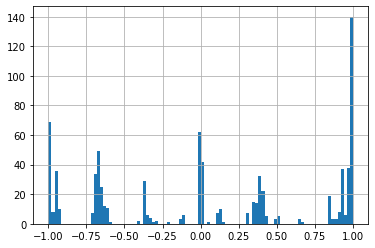

In [118]:
torsions.hist(bins=100)

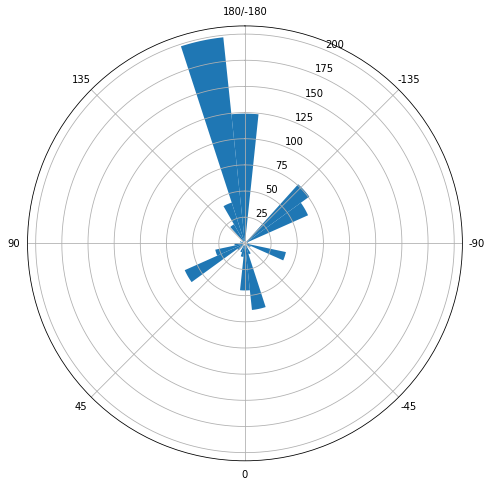

In [120]:
get_radial_hist(torsions * np.pi, 30)

In [83]:
np.array([-1.0, -0.66, -.33, 0, .33, .66, 1]) * 180

array([-180. , -118.8,  -59.4,    0. ,   59.4,  118.8,  180. ])

In [301]:
m = Chem.MolFromSmiles('CCCCCCCCCCCC')
m = Chem.AddHs(m)
AllChem.EmbedMultipleConfs(m, numConfs=400, numThreads=0)
res = AllChem.MMFFOptimizeMoleculeConfs(m, numThreads=0)
nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)
    
w = nv.show_rdkit(m)
w.add_label(labelType="atomindex", color='blue')
w

NGLWidget()

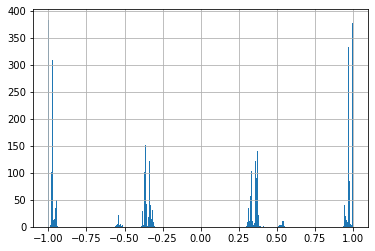

In [302]:
torsions = bag_of_dihedrals(m)
torsions /= (180)
torsions.hist(bins=400)

In [303]:
torsions *= 2*np.pi

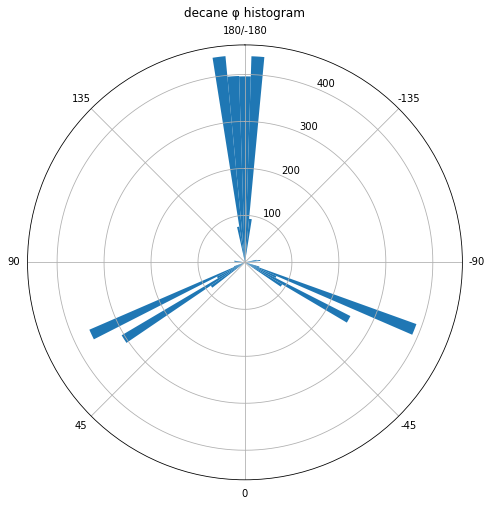

In [306]:
get_radial_hist(torsions, 100)

In [229]:
torsions

0    -6.277789
1    -6.118320
2    -2.304177
3    -6.118787
4    -6.277370
5    -6.281837
6    -6.278311
7    -6.131964
8    -2.291107
9    -2.291598
10   -6.132715
11    6.282305
12    6.110878
13    2.352200
14   -6.271489
15   -2.110899
16   -2.062938
17   -6.111348
dtype: float64

In [230]:
conf = m.GetConformer(0)
print_dihedrals(conf)

nonring
(0, 1, 2, 3) -179.84539870751848
(1, 2, 3, 4) -175.27696985984258
(2, 3, 4, 5) -66.00980518637824
(3, 4, 5, 6) -175.29033538933032
(4, 5, 6, 7) -179.8333903303334
(5, 6, 7, 8) -179.96138013540428
(6, 7, 8, 9) -179.86036008612078
(7, 8, 9, 10) -175.66782652516318
(8, 9, 10, 11) -65.63537660043566


In [270]:
nonring, ring = TorsionFingerprints.CalculateTorsionLists(m)


x = [
    -180,
    -180,
    -180,
    -180,
    -180,
    -180,
    -180,
    -180,
    -180,
]

y = [
    -180,
    -180,
    -180,
    -180,
    -180,
    -180,
    -180,
    -180,
    -180,
]

conf = m.GetConformer(id=0)

for idx, tors in enumerate(nonring):
    atoms, ang = tors
    tup = atoms[0]
    deg = Chem.rdMolTransforms.GetDihedralDeg(conf, *tup)
    Chem.rdMolTransforms.SetDihedralDeg(conf, *tup, x[idx])

conf = m.GetConformer(id=1)

for idx, tors in enumerate(nonring):
    atoms, ang = tors
    tup = atoms[0]
    deg = Chem.rdMolTransforms.GetDihedralDeg(conf, *tup)
    Chem.rdMolTransforms.SetDihedralDeg(conf, *tup, y[idx])
    
    


In [271]:
m.GetConformers()

(<rdkit.Chem.rdchem.Conformer at 0x7f8ed4ed3240>,
 <rdkit.Chem.rdchem.Conformer at 0x7f8ed4ed3818>)

In [272]:
confgen.get_conformer_energies(m)

array([-6.02906893, -5.03576563])

In [273]:
AllChem.GetConformerRMS(m, 0, 1)

1.1724221596635498

In [274]:
Chem.TorsionFingerprints.GetTFDBetweenConformers(m, [0], [1])

[3.8478321840029904e-10]

In [298]:
p = py3Dmol.view(width=800,height=800)
drawit(m, p, confId=0)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [300]:
AllChem.MMFFOptimizeMoleculeConfs(m)
print(confgen.get_conformer_energies(m))
print(AllChem.GetConformerRMS(m, 0, 1))
print(Chem.TorsionFingerprints.GetTFDBetweenConformers(m, [0], [1]))

[-6.71287903 -6.71287902]
1.1794663504444367
[1.4362777388374274e-06]


In [12]:
conf = lignin.GetConformer(id=-1)

In [18]:
torch.Tensor(conf.GetPositions())

torch.Size([46, 3])

In [16]:
import torch

In [21]:
atom = lignin.GetAtomWithIdx(0)

In [22]:
atom.GetIdx()

0

In [55]:
conf.GetOwningMol()

46

In [28]:
nonring, ring = TorsionFingerprints.CalculateTorsionLists(lignin)
print(nonring)
print('\n')
print(ring)

[([(2, 1, 4, 5)], 180.0), ([(4, 1, 2, 14)], 180.0), ([(4, 1, 0, 3)], 180.0), ([(6, 5, 4, 1)], 180.0), ([(5, 6, 11, 12)], 180.0), ([(15, 14, 2, 1)], 180.0), ([(22, 20, 18, 19)], 180.0), ([(23, 21, 19, 18)], 180.0)]


[([(6, 8, 10, 9), (8, 10, 9, 7), (10, 9, 7, 5), (9, 7, 5, 6), (7, 5, 6, 8), (5, 6, 8, 10)], 36.34137323903797), ([(15, 17, 19, 18), (17, 19, 18, 16), (19, 18, 16, 14), (18, 16, 14, 15), (16, 14, 15, 17), (14, 15, 17, 19)], 36.34137323903797)]


In [37]:
def bond_features(bond, use_chirality=False):
    from rdkit import Chem
    bt = bond.GetBondType()
    bond_feats = [
        bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
        bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
        bond.GetIsConjugated(),
        bond.IsInRing()
    ]
    if use_chirality:
        bond_feats = bond_feats + one_of_k_encoding_unk(
            str(bond.GetStereo()),
            ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"])
    return np.array(bond_feats)
 
#################
# pen added
#################
def get_bond_pair(mol):
    bonds = mol.GetBonds()
    res = [[],[]]
    for bond in bonds:
        res[0] += [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
        res[1] += [bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]
    return res

def atom_features_simple(atom, conf):
    p = conf.GetAtomPosition(atom.GetIdx())
    return np.array([p.x, p.y, p.z])


def mol2vecsimple(mol):
    conf = mol.GetConformer(id=-1)
    atoms = mol.GetAtoms()
    bonds = mol.GetBonds()
    node_f= [atom_features_simple(atom, conf) for atom in atoms]
    edge_index = get_bond_pair(mol)
    edge_attr = [bond_features(bond, use_chirality=False) for bond in bonds]
    for bond in bonds:
        edge_attr.append(bond_features(bond))
    data = Data(
                x=torch.tensor(node_f, dtype=torch.float),
                edge_index=torch.tensor(edge_index, dtype=torch.long),
                edge_attr=torch.tensor(edge_attr,dtype=torch.float),
                pos=torch.Tensor(conf.GetPositions())
            )
    data = Distance()(data)
    return data    



[([(0, 1, 2, 3)], 180.0), ([(1, 2, 3, 4)], 180.0), ([(2, 3, 4, 5)], 180.0)] 
 []


NGLWidget()

In [41]:
conf = lignin.GetConformer(id=0)

In [42]:
conf.GetPositions()

array([[-5.47897655e-01, -1.71843654e+00, -8.53177358e-01],
       [-8.72552250e-01, -4.44519817e-01, -5.90009200e-02],
       [-3.91934647e-01, -5.15678216e-01,  1.41973019e+00],
       [-1.29161246e+00, -2.82538499e+00, -3.35395107e-01],
       [-2.31477476e+00, -2.95478211e-01, -1.48109006e-02],
       [-2.78959112e+00,  5.08792996e-01, -1.01927837e+00],
       [-3.45612062e+00, -6.71472573e-02, -2.11158114e+00],
       [-2.69139579e+00,  1.89444349e+00, -8.81831784e-01],
       [-3.97926217e+00,  7.73536377e-01, -3.09627209e+00],
       [-3.22354779e+00,  2.72225729e+00, -1.86677435e+00],
       [-3.86003874e+00,  2.16253551e+00, -2.97415596e+00],
       [-3.51690346e+00, -1.43677650e+00, -2.13266848e+00],
       [-4.43568312e+00, -2.01981487e+00, -3.04882395e+00],
       [-8.61235773e-01, -1.68287430e+00,  2.10760411e+00],
       [ 1.11399869e+00, -3.80543149e-01,  1.56432837e+00],
       [ 1.92919230e+00, -1.47681424e+00,  1.87359963e+00],
       [ 1.72161083e+00,  8.72362996e-01

In [52]:
x = lignin.GetConformer(id=1).GetPositions()

In [54]:
x[0][0] = 0

In [55]:
lignin.GetConformer(id=1).GetPositions()

array([[-0.88910166, -2.20206874,  0.04913495],
       [-0.62311212, -1.06650061, -0.95066788],
       [ 0.89584075, -0.93915922, -1.26534267],
       [-0.50319458, -3.46885891, -0.48180212],
       [-1.14711269,  0.1613215 , -0.39996863],
       [-2.02674261,  0.77990795, -1.25481494],
       [-3.34522686,  0.32836871, -1.42537153],
       [-1.5814084 ,  1.93922236, -1.89240113],
       [-4.19177877,  1.03522116, -2.28596992],
       [-2.43533732,  2.63805046, -2.74272004],
       [-3.73724953,  2.18414829, -2.94217375],
       [-3.70359817, -0.79905692, -0.73531409],
       [-5.0914046 , -1.09901884, -0.66591327],
       [ 1.1186278 ,  0.04704761, -2.28588095],
       [ 1.79404571, -0.63659238, -0.07826326],
       [ 2.66016978, -1.61887961,  0.4164039 ],
       [ 1.77813813,  0.62094909,  0.54545834],
       [ 3.49796731, -1.35180484,  1.50342015],
       [ 2.60083288,  0.89267118,  1.6460169 ],
       [ 3.47996404, -0.09809954,  2.1217001 ],
       [ 2.63108717,  2.10296275,  2.296

In [56]:
x = lignin.GetConformer(id=1).GetPositions()

In [68]:
from time import time
start = time()

[lignin.GetConformer(id=1).SetAtomPosition(i, Point3D(0,0,0)) for i,atom in enumerate(x)]


0.0003123283386230469


In [70]:
lignin = Chem.MolFromMolFile('lignin_guaiacyl.mol')
lignin = Chem.AddHs(lignin)
from time import time
start = time()
AllChem.EmbedMultipleConfs(lignin, numConfs=1, numThreads=0)
Chem.AllChem.MMFFOptimizeMoleculeConfs(lignin)
print(time()- start)

0.045007944107055664


In [71]:
nonring, ring = TorsionFingerprints.CalculateTorsionLists(lignin)
print(nonring)

[([(2, 1, 4, 5)], 180.0), ([(4, 1, 2, 14)], 180.0), ([(4, 1, 0, 3)], 180.0), ([(6, 5, 4, 1)], 180.0), ([(5, 6, 11, 12)], 180.0), ([(15, 14, 2, 1)], 180.0), ([(22, 20, 18, 19)], 180.0), ([(23, 21, 19, 18)], 180.0)]


In [72]:
len(nonring)

8

In [58]:
import graphenvironments
import gym
gym.envs.register(
     id='Lignin-v0',
     entry_point='graphenvironments:LigninEnv',
     max_episode_steps=1000,
)

gym.envs.register(
     id='Lignin-v1',
     entry_point='graphenvironments:LigninSetEnv',
     max_episode_steps=1000,
)


gym.envs.register(
     id='Carbon-v0',
     entry_point='graphenvironments:BranchedCarbonSet',
     max_episode_steps=1000,
)

gym.envs.register(
     id='Trihexyl-v0',
     entry_point='graphenvironments:TrihexylSet',
     max_episode_steps=1000,
)

Error: Cannot re-register id: Lignin-v0

In [78]:
gym.envs.register(
     id='Diff-v0',
     entry_point='graphenvironments:DifferentCarbonSet',
     max_episode_steps=1000,
)

In [81]:
env = gym.make('Diff-v0')

In [82]:
env.reset()

step time mean nan
reset called
[-61.63528837293491, 179.6776959710148, -61.406728122519695, -56.33261515355065, -56.26255100160326, 178.8389084181216, -71.03555527002123, 179.74563449451313, 65.69184253573596, -60.83763544654525]


/home/tgog/conformer-ml/graphenvironments.py:581: RuntimeWarning: Mean of empty slice.


(Batch(batch=[47], edge_attr=[92, 7], edge_index=[2, 92], pos=[47, 3], x=[47, 3]),
 [[0, 1, 2, 3],
  [1, 2, 3, 4],
  [0, 1, 5, 6],
  [1, 5, 6, 7],
  [5, 6, 7, 8],
  [6, 7, 8, 9],
  [7, 8, 9, 10],
  [8, 9, 10, 11],
  [9, 10, 11, 12],
  [7, 8, 13, 14]])

In [83]:
done = False
rewards = 0
while not done:
    _, reward, done, _ = env.step(np.random.randint(0,6,10))
    print(reward)
    rewards += reward
    
print(rewards)

action is  [2 5 2 4 4 3 4 1 0 4]
standard_energy 7.867282859932096
reward is  0.025286520911986896
new state is:
[-63.341465167977226, -178.37707632091804, -88.28109430948086, 70.0867633005089, 56.23758154591568, 53.77680538897507, 60.43177453476125, -179.85519550260747, 179.89986102320267, 67.32674315231516]
0.025286520911986896
action is  [3 2 3 3 0 0 5 3 4 3]
standard_energy 7.867282859932096
reward is  1.6963597094017001e-06
new state is:
[-44.29598641520342, -65.01856792537075, -61.02358885915982, 98.5599808071884, -177.36014666836192, 164.7899460489423, 64.1373073989664, 103.25278670653802, 72.69518990407909, -43.1276743799853]
1.6963597094017001e-06
action is  [1 4 0 1 3 4 1 1 5 0]
standard_energy 7.867282859932096
reward is  7.936971517829355e-07
new state is:
[-81.16246801920924, 61.40110309413523, -164.1410150980946, -174.0324984656159, -87.43182397809738, 74.34353763117441, -106.98354379072677, -81.71228353536785, 99.21526390947204, 170.68743942022905]
7.936971517829355e-07


standard_energy 7.867282859932096
reward is  1.1007982349249835e-05
new state is:
[-78.93110978782929, 77.24980906904761, 46.94132669645261, -98.16955257947131, 179.27658973958916, -69.99927294466107, 94.93907100195078, -170.28853509738875, -178.44022841118135, 58.85590790613909]
1.1007982349249835e-05
action is  [0 0 1 0 1 2 3 1 3 1]
standard_energy 7.867282859932096
reward is  0.02723339674120525
new state is:
[169.03486919043084, -175.7707830715514, -59.96765790800674, -174.74371502994282, -175.97447968695323, -41.198878069764675, -64.49993167437412, 175.85691198897544, 64.54713283934124, -65.14194516025694]
0.02723339674120525
action is  [1 1 4 2 1 2 1 5 5 5]
standard_energy 7.867282859932096
reward is  0.04964312047953002
new state is:
[170.0031288260953, -177.70105274338113, 82.84131144592, -65.12801871266501, -168.5270558444675, -63.826004782154946, -166.97282952945778, 174.18032180774463, 179.48035795699323, 52.48344468510025]
0.04964312047953002
action is  [2 4 0 5 5 0 1 2 0 5

[96.830520831289, -63.91352131106192, -59.90036958215555, -55.96270326113252, -55.062338307586955, 177.5767879303207, -59.99925309158306, -171.56592368015927, -179.58823670748887, 176.29377264163884]
0.012241243464872313
action is  [3 4 0 1 4 1 2 5 5 3]
standard_energy 7.867282859932096
reward is  0.00029363600351679775
new state is:
[55.694809592408916, 59.4327775555536, -170.78914866642938, 173.1624782900586, 98.60878068698271, -69.55562274185411, -74.41475268230936, 96.30149205149829, 175.17754714022638, 53.47140910317211]
0.00029363600351679775
action is  [1 5 5 5 2 4 0 2 0 0]
standard_energy 7.867282859932096
reward is  3.1879004899345407e-06
new state is:
[169.8498540972545, 94.82729130913225, -140.50553902268265, 78.56006620637987, -174.27351896635574, 167.7290178437617, -167.5377389802244, -96.14254974507274, -176.6719823900469, 136.68789185191116]
3.1879004899345407e-06
action is  [0 4 5 2 4 0 4 2 0 4]
standard_energy 7.867282859932096
reward is  2.4222183192972124e-09
new sta

[-73.31331942640595, -176.33816749866236, 139.32568764212584, 72.70958481774991, -98.98566894382239, 145.86403298698644, 74.91563430415164, -71.87596616230134, -63.075804238340446, 65.44565043133443]
8.188200074729665e-06
action is  [3 1 0 4 2 0 5 4 3 0]
standard_energy 7.867282859932096
reward is  2.39492897094965e-06
new state is:
[59.2547613650709, 178.855152424737, 145.41938703662586, 71.15244650909597, -105.08467856876389, 167.76725494362117, -175.7893249614885, 90.93135806739916, -71.00423504702907, 127.99011225890195]
2.39492897094965e-06
action is  [5 4 0 4 5 3 1 3 5 3]
standard_energy 7.867282859932096
reward is  0.001550173484225223
new state is:
[-175.14769701008555, 64.99050768863933, 141.20198899781866, -179.91742230739806, -74.29574576047814, 139.54862980643767, -71.32552896889588, -71.85204464655105, -178.42924906139177, 62.57732980117586]
0.001550173484225223
action is  [1 3 4 2 5 3 0 2 4 2]
standard_energy 7.867282859932096
reward is  0.06752167707678144
new state is:


reward is  0.0008333223495020918
new state is:
[-58.38646304013144, -173.93434798672257, 172.97798912984487, -171.79041984073555, 100.71384316657091, 173.18813135183308, -59.790379382720886, -54.72176906552725, -59.90598366101013, 92.13849704757712]
0.0008333223495020918
action is  [3 5 3 0 0 2 0 4 0 1]
standard_energy 7.867282859932096
reward is  0.0009521307204611656
new state is:
[45.829976063229424, 65.76100960108943, 66.38626178083844, 174.80628352418512, 171.39115077647455, -67.95377908405513, -168.36837589733068, 64.41541691627928, 174.2184060415722, -87.16614219610474]
0.0009521307204611656
action is  [0 1 5 4 2 5 2 3 5 2]
standard_energy 7.867282859932096
reward is  0.0003914851066913235
new state is:
[-163.64924968625093, 177.79038121460894, 73.87261766354887, 103.71557644264085, -66.06634235758972, 171.17094449612742, -96.43271505841963, 67.11200281025162, 64.71308086237117, -60.05687767618069]
0.0003914851066913235
action is  [2 3 5 1 2 0 0 1 1 0]
standard_energy 7.86728285

standard_energy 7.867282859932096
reward is  0.0010334169008838583
new state is:
[-63.329136145471814, -177.0479945990165, -71.48391244047738, 83.14761214580665, 178.27756671139986, 51.518016055342436, 58.045619381761334, 102.04279320188535, -174.95013916541805, 66.59394751228017]
0.0010334169008838583
action is  [0 3 0 5 4 0 5 5 0 4]
standard_energy 7.867282859932096
reward is  3.832327602800536e-06
new state is:
[-170.5998837685415, 61.04615565070719, 107.31160103976042, -157.45892138026238, 159.2772075795127, 173.43825306676064, 68.30774373710838, -175.35294558442658, 174.33286537768146, 112.00410563857172]
3.832327602800536e-06
action is  [2 1 2 1 2 1 0 5 0 4]
standard_energy 7.867282859932096
reward is  0.031242152533759605
new state is:
[-72.15085629282505, -179.00668676934114, -46.63374831839828, -64.30108974596762, -167.29214503147796, -63.525113300997, -165.47362101830944, 175.02419523575847, 179.9807372011445, 52.89132649192822]
0.031242152533759605
action is  [2 0 1 0 3 0 5 

standard_energy 7.867282859932096
reward is  0.0003599174610926015
new state is:
[-172.85697710340213, 178.19143858818592, -61.77540400752516, -91.369853496947, -173.44498213215869, -139.31226671618774, 90.8240992345193, -66.30179261691244, -174.3404696188371, -61.31402245491719]
0.0003599174610926015
action is  [0 1 3 5 5 0 1 2 1 3]
standard_energy 7.867282859932096
reward is  0.7310294394998842
new state is:
[-176.07005791527112, 174.9689865687881, -67.55761030880184, 178.82262529365855, 173.56858476672957, -175.38774957570166, 178.15170204768785, -59.887086963335456, -175.16958540040292, 61.53932686190282]
0.7310294394998842
action is  [1 2 4 5 3 0 3 3 1 5]
standard_energy 7.867282859932096
reward is  0.0006009708088870147
new state is:
[-144.78561053800152, -68.67360885819008, 58.30686918214455, 54.75460785636557, 56.43787908433892, -170.05817436662994, -65.94303028018848, 97.85396407336881, 179.15558522971256, 179.11526612098316]
0.0006009708088870147
action is  [0 0 4 1 2 4 3 1 3

standard_energy 7.867282859932096
reward is  0.0001971483773083469
new state is:
[-57.28238388607571, -59.71469007536457, 178.47259282884608, -51.92781394657426, -80.25418048555109, 71.32137408811346, 160.90106386855874, 101.89690782826389, 68.69291393729837, -51.96312267032163]
0.0001971483773083469
action is  [4 1 5 5 5 3 2 2 5 4]
standard_energy 7.867282859932096
reward is  2.4405158659016895e-06
new state is:
[63.739913198672895, -95.83515399742579, 175.92462479233518, 97.71942098405029, 175.49992223975275, -60.861507667678715, -60.54886589589367, -98.72566268562834, 177.8463026767721, 39.54947109619265]
2.4405158659016895e-06
action is  [3 2 3 1 2 1 0 3 5 3]
standard_energy 7.867282859932096
reward is  0.0001393387101558425
new state is:
[-60.24904839161088, -61.072929018372875, -44.081544973153306, -68.55438903241001, -56.029480273538994, -63.959520918190975, 130.73927925095308, 66.33854281873009, 68.13809516556509, -68.48322069114862]
0.0001393387101558425
action is  [0 5 0 4 5 

In [49]:
import numpy as np
np.random.randint(0,5,8)

array([2, 1, 1, 1, 1, 3, 3, 1])

In [48]:
help(np.random.randint)

Help on built-in function randint:

randint(...) method of mtrand.RandomState instance
    randint(low, high=None, size=None, dtype='l')
    
    Return random integers from `low` (inclusive) to `high` (exclusive).
    
    Return random integers from the "discrete uniform" distribution of
    the specified dtype in the "half-open" interval [`low`, `high`). If
    `high` is None (the default), then results are from [0, `low`).
    
    Parameters
    ----------
    low : int
        Lowest (signed) integer to be drawn from the distribution (unless
        ``high=None``, in which case this parameter is one above the
        *highest* such integer).
    high : int, optional
        If provided, one above the largest (signed) integer to be drawn
        from the distribution (see above for behavior if ``high=None``).
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are drawn.  Default is None, i

In [80]:
import importlib
importlib.reload(graphenvironments)

<module 'graphenvironments' from '/home/tgog/conformer-ml/graphenvironments.py'>